In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [18]:
pre = pd.read_csv('anon_pre.csv')
post = pd.read_csv('anon_post.csv')
# TODO : FIGURE OUT WHY THERE ARE NANS IN THE POST DATA RESPONSE IDs

post.dropna(subset=['ResponseId'], inplace=True)

post['ResponseId'] = post['ResponseId'].astype('str')

cis = pd.read_csv('anon_cis.csv')
cis['ResponseId'] = cis.ResponseId.astype('str')

matched = pre.merge(post, on=['anon_student_id', 'ResponseId'], suffixes=['_pre', '_post'])

In [19]:
print('----Overview----')
print('Total number of instances of the survey everywhere:', cis.shape[0])
print('Number of unique universities in data set:', cis.anon_university_id.nunique())

print('Number of unique instructors in data set:', cis.anon_instructor_id.nunique())

# this works becuase students were given anonymous IDs sequentially starting from 0
print('Number of unique students in data set (unmatched):', post.anon_student_id.max())

# this is checking if the students answered at least the first question of both pre and post and then calling that matched.
print('Number of unique students in data set (matched):', matched.index.nunique())

print('Number of instructors with repeated surveys:', cis.groupby('anon_instructor_id').count().groupby('Q5').count().Q52.iloc[1:].sum())

print('Number of universities with repeated surveys:', cis.groupby('anon_university_id').count().groupby('Q5').count().Q52.iloc[1:].sum())

print('Number of students with repeated surveys:', matched.groupby('anon_student_id').filter(lambda x: len(x) > 1).shape[0])

print('\n')
# combines the pre and cis and post and cis to get an unmatched number of survey completion
# Q19 is the CIS question about the number of enrolled students
pre_completion = pre.groupby('survey_id').count().anon_student_id.reset_index()
pre_completion.columns = ['pre_survey_id', 'pre_cnt']
post_completion = post.groupby('survey_id').count().anon_student_id.reset_index()
post_completion.columns = ['post_survey_id', 'post_cnt']
cisq19 = cis[['Q19', 'pre_survey_id', 'post_survey_id']]
pre19 = cisq19.merge(pre_completion)
post19 = cisq19.merge(post_completion)

# combines the pre, post, and cis data to get a matched number of survey completion
matched_cnt = pre.set_index('anon_student_id').join(post.set_index('anon_student_id'), rsuffix='_post').dropna(subset=['q01a', 'q01a_post']).groupby('survey_id').count().duration.reset_index()
matched_cnt.columns = ['pre_survey_id', 'cnt']
matched_cnt = cis.merge(matched_cnt)[['pre_survey_id', 'Q19', 'cnt']]


print('Number of surveys with more student respondents than reported maximum registered students (PRE):', (pre19.pre_cnt/pre19.Q19).apply(lambda x: x if x > 1 else np.nan).dropna().shape[0])
print('Number of surveys with more student respondents than reported maximum registered students (POST):', (post19.post_cnt/post19.Q19).apply(lambda x: x if x > 1 else np.nan).dropna().shape[0])

print('Number of surveys with more student respodnents than repored maximum registered students (MATCHED):', (matched_cnt.cnt/matched_cnt.Q19).apply(lambda x: x if x > 1 else np.nan).dropna().shape[0])

print('Average fraction +\- STDEV of course completing the PRE survey:', round((pre19.pre_cnt/pre19.Q19).apply(lambda x: x if x <= 1 else np.nan).dropna().mean(), 2), '+/-', round((pre19.pre_cnt/pre19.Q19).apply(lambda x: x if x <= 1 else np.nan).dropna().std(), 2)
)
print('Average +\- STDEV fraction of course completing the POST survey:', round((post19.post_cnt/post19.Q19).apply(lambda x: x if x <= 1 else np.nan).dropna().mean(), 2), '+/-', round((post19.post_cnt/post19.Q19).apply(lambda x: x if x <= 1 else np.nan).dropna().std(), 2))
print('Average +\- STDEV fraction of course completing the MATCHED survey:', round((matched_cnt.cnt/matched_cnt.Q19).apply(lambda x: x if x <= 1 else np.nan).dropna().mean(), 2), '+/-', round((matched_cnt.cnt/matched_cnt.Q19).apply(lambda x: x if x <= 1 else np.nan).dropna().std(), 2))

print('\n')

print('----Gender----')
print('''
:::Notes:::
1.) the reason there is 43081 unmatched students but there is far fewer total students in unmatched gender response is because students are asked their gender in the post survey. There is an average ~50% matched response rate. So there is going to be of course much fewer responses even in the unmatched set.
''')
# unmatched_gender = post.groupby('Q54').count().anon_student_id
unmatched_gender = post[['anon_student_id', 'Q54']].drop_duplicates().groupby('Q54').count().anon_student_id
print('Number of females in data set (unmatched):', unmatched_gender[1])
print('Number of males in data set (unmatched):', unmatched_gender[2])
print('Number of other in data set (unmatched):', unmatched_gender[3])
print('\n')

# matched_gender = matched.groupby('Q54').count().anon_student_id
matched_gender = matched[['anon_student_id', 'Q54']].drop_duplicates().groupby('Q54').count().anon_student_id
print('Number of females in data set (matched):', matched_gender[1])
print('Number of males in data set (matched):', matched_gender[2])
print('Number of other in data set (matched):', matched_gender[3])
print('\n')


print('----Race (unmatched)----')
unmatched_race = post[['anon_student_id', 'Q52_1', 'Q52_2', 'Q52_3', 'Q52_4', 'Q52_5', 'Q52_6', 'Q52_7']].drop_duplicates()
print('American Indian or Alaska Native:', unmatched_race.Q52_1.sum())
print('Asian:', unmatched_race.Q52_2.sum())
print('Black or African American:', unmatched_race.Q52_3.sum())
print('Hispanic/Latino:', unmatched_race.Q52_4.sum())
print('Native Hawaiian or other Pacific Islander:', unmatched_race.Q52_5.sum())
print('White:', unmatched_race.Q52_6.sum())
print('Other race/ethnicity:', unmatched_race.Q52_7.sum())
s = unmatched_race[['Q52_1', 'Q52_2', 'Q52_3', 'Q52_4', 'Q52_5', 'Q52_6', 'Q52_7']].sum(axis=1)
print('More than one race:', s.where(s > 1).count())
print('\n')

print('----Race (matched)----')
matched_race = matched[['anon_student_id', 'Q52_1', 'Q52_2', 'Q52_3', 'Q52_4', 'Q52_5', 'Q52_6', 'Q52_7', 'race_unknown']].drop_duplicates()
print('American Indian or Alaska Native:', matched_race.Q52_1.sum())
print('Asian:', matched_race.Q52_2.sum())
print('Black or African American:', matched_race.Q52_3.sum())
print('Hispanic/Latino:', matched_race.Q52_4.sum())
print('Native Hawaiian or other Pacific Islander:', matched_race.Q52_5.sum())
print('White:', matched_race.Q52_6.sum())
print('Other race/ethnicity:', matched_race.Q52_7.sum())
s = matched_race[['Q52_1', 'Q52_2', 'Q52_3', 'Q52_4', 'Q52_5', 'Q52_6', 'Q52_7']].sum(axis=1)
print('More than one race:', s.where(s > 1).count())
print('Race Unknown:', matched_race.race_unknown.sum())
print('\n')

print('----Course information----')
course_type = cis.groupby('Q18')

print('Number of times survey given to students in first year lab:', course_type.count().Q5.loc['First year (introductory) lab'])
print('Number of times survey given to students in BUFFY lab courses:', course_type.count().Q5.loc['Beyond the first year lab'])

## haha, i guess its not a good assumption to think its normally distributed course enrollment numbers
print('Average +/- STDEV students in first year lab:', course_type.mean().Q19.loc['First year (introductory) lab'].round(2), '+/-',course_type.std().Q19.loc['First year (introductory) lab'].round(2))
print('Average +/- STDEV students in BUFFY lab courses:', course_type.mean().Q19.loc['Beyond the first year lab'].round(2), '+/-', course_type.std().Q19.loc['Beyond the first year lab'].round(2))

course_type = cis.groupby('Q27')
print('Algebra based intro courses:', course_type.count().Q5.loc['Algebra-based'])
print('Calculus based intro courses:', course_type.count().Q5.loc['Calculus-based'])

----Overview----
Total number of instances of the survey everywhere: 599
Number of unique universities in data set: 133
Number of unique instructors in data set: 204
Number of unique students in data set (unmatched): 43080
Number of unique students in data set (matched): 22541
Number of instructors with repeated surveys: 100
Number of universities with repeated surveys: 80
Number of students with repeated surveys: 3907


Number of surveys with more student respondents than reported maximum registered students (PRE): 32
Number of surveys with more student respondents than reported maximum registered students (POST): 17
Number of surveys with more student respodnents than repored maximum registered students (MATCHED): 51
Average fraction +\- STDEV of course completing the PRE survey: 0.71 +/- 0.25
Average +\- STDEV fraction of course completing the POST survey: 0.58 +/- 0.25
Average +\- STDEV fraction of course completing the MATCHED survey: 0.49 +/- 0.26


----Gender----

:::Notes:::
1.

array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,
        0.16,  0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,
        0.34,  0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,
        0.52,  0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,
        0.7 ,  0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,
        0.88,  0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ])

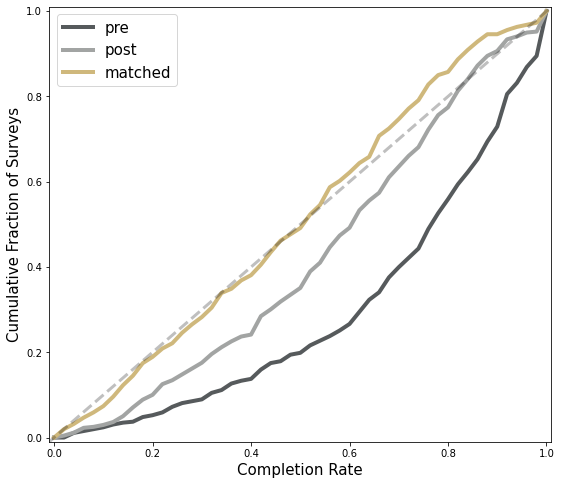

In [20]:
fig, ax = plt.subplots(figsize=(9, 8))

predata = pre19.pre_cnt/pre19.Q19
postdata = post19.post_cnt/post19.Q19
# predata = pre19.pre_cnt/pre19.Q19
matchdata = matched_cnt.cnt/matched_cnt.Q19

def gethist(data):
    h, e = np.histogram(data, bins=np.linspace(-0.02, 1.0, 52))
    h = h/h.sum()
    return h, e

h, e = gethist(predata[predata <= 1])
ax.plot(e[1:], h.cumsum(), label='pre', color='#565A5C', linewidth=4)

h, e = gethist(postdata[postdata <= 1])
ax.plot(e[1:], h.cumsum(), label='post', color='#A2A4A3', linewidth=4)

h, e = gethist(matchdata[matchdata <= 1])
ax.plot(e[1:], h.cumsum(), label='matched', color='#CFB87C', linewidth=4)

ax.plot([-2, 2], [-2, 2], linestyle='--', color='black', alpha=0.25, linewidth=3)

ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel('Completion Rate', fontsize=15)
ax.legend(fontsize=15)
ax.set_ylabel('Cumulative Fraction of Surveys', fontsize=15)
e

**FIGURE 1:** Completion rate by survey. Faculty are asked to report the total number of expected students to enroll in their course. Using this number as the upper limit, the completion rate is calculated for students who take the pre-survey (blue), post-survey (orange), and both (green). The diagonal represents an equal completion rate for the fraction of surveys. For matched data, approximately 50% of the courses surveyed have at least 50% of the students responding. When instructors report an expected number of student respondents smaller than the number of respondents to the survey, this is not used in this graph.

In [21]:
cis.Q18.unique()

array(['First year (introductory) lab', 'Beyond the first year lab'],
      dtype=object)

In [22]:
pre19 = pre19.merge(cis)[['Q19', 'pre_survey_id', 'post_survey_id', 'pre_cnt', 'Q18']]
pre19['ratio'] = pre19.pre_cnt/pre19.Q19

post19 = post19.merge(cis)[['Q19', 'pre_survey_id', 'post_survey_id', 'post_cnt', 'Q18']]


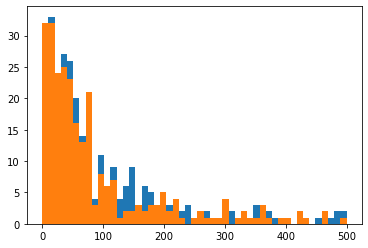

In [23]:
fig, ax = plt.subplots()

pre19[(pre19['Q18']=='First year (introductory) lab')].pre_cnt.hist(bins=np.linspace(0, 500, 50), ax=ax, grid=False)

post19[(post19['Q18']=='First year (introductory) lab')].post_cnt.hist(bins=np.linspace(0, 500, 50), ax=ax, grid=False)

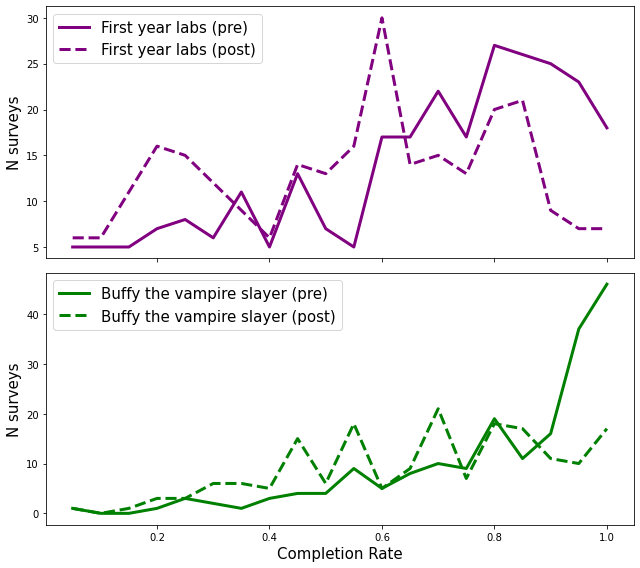

In [50]:
first = cis[cis.Q18=='First year (introductory) lab'].merge(pre)
buffy = cis[cis.Q18=='Beyond the first year lab'].merge(pre)

prefirst = first.groupby('ResponseId').count()[['Q5']].join(cis.set_index('ResponseId'), rsuffix='_cis')

prebuffy = buffy.groupby('ResponseId').count()[['Q5']].join(cis.set_index('ResponseId'), rsuffix='_cis')

first = cis[cis.Q18=='First year (introductory) lab'].merge(post, on=['ResponseId'])
buffy = cis[cis.Q18=='Beyond the first year lab'].merge(post, on=['ResponseId'])

postfirst = first.groupby('ResponseId').count()[['Q5']].join(cis.set_index('ResponseId'), rsuffix='_cis')

postbuffy = buffy.groupby('ResponseId').count()[['Q5']].join(cis.set_index('ResponseId'), rsuffix='_cis')


fig, (ax, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

### PRE
h, e = np.histogram(prefirst.Q5/prefirst.Q19, bins=np.linspace(0, 1, 21))
ax.plot(e[1:], h, label='First year labs (pre)', linewidth=3, color='purple')

h, e = np.histogram(prebuffy.Q5/prebuffy.Q19, bins=np.linspace(0, 1, 21))
ax2.plot(e[1:], h, label='Buffy the vampire slayer (pre)', linewidth=3, color='green')

### POST
h, e = np.histogram(postfirst.Q5/postfirst.Q19, bins=np.linspace(0, 1, 21))
ax.plot(e[1:], h, label='First year labs (post)', linewidth=3, color='purple', linestyle='--')

h, e = np.histogram(postbuffy.Q5/postbuffy.Q19, bins=np.linspace(0, 1, 21))
ax2.plot(e[1:], h, label='Buffy the vampire slayer (post)', linewidth=3, color='green', linestyle='--')


ax.legend(fontsize=15)
ax2.set_xlabel('Completion Rate', fontsize=15)
ax.set_ylabel('N surveys', fontsize=15)
ax2.set_ylabel('N surveys', fontsize=15)
ax2.legend(fontsize=15)
fig.tight_layout()

In [35]:
cis.merge(post, on=['ResponseId'])

,Q5,Q52,Q53_x,Q18,Q27,Q6,Q11,Q19,Q20,Q15,...,q28c,q29a,q29b,q30a,q30b,q30c,q31a,q31b,q40a,q40b
0,semester,Spring,NaN,First year (introductory) lab,Calculus-based,01/28/2019,Extra credit for completion,175,8,NaN,...,4.0,3.0,5.0,1.0,1.0,3.0,5.0,5.0,4.0,4.0
1,semester,Spring,NaN,First year (introductory) lab,Calculus-based,01/28/2019,Extra credit for completion,175,8,NaN,...,5.0,5.0,5.0,3.0,3.0,4.0,5.0,5.0,4.0,4.0
2,semester,Spring,NaN,First year (introductory) lab,Calculus-based,01/28/2019,Extra credit for completion,175,8,NaN,...,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,4.0,4.0
3,semester,Spring,NaN,First year (introductory) lab,Calculus-based,01/28/2019,Extra credit for completion,175,8,NaN,...,4.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,4.0,4.0
4,semester,Spring,NaN,First year (introductory) lab,Calculus-based,01/28/2019,Extra credit for completion,175,8,NaN,...,5.0,5.0,5.0,NaN,NaN,5.0,5.0,5.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31088,quarter,NaN,Fall,First year (introductory) lab,Calculus-based,09/04/2018,Credit for completion (like an assignment),400,14,NaN,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0
31089,quarter,NaN,Fall,First year (introductory) lab,Calculus-based,09/04/2018,Credit for completion (like an assignment),400,14,NaN,...,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,4.0,4.0
31090,quarter,NaN,Fall,First year (introductory) lab,Calculus-based,09/04/2018,Credit for completion (like an assignment),400,14,NaN,...,5.0,1.0,5.0,1.0,5.0,4.0,5.0,5.0,4.0,4.0
31091,quarter,NaN,Fall,First year (introductory) lab,Calculus-based,09/04/2018,Credit for completion (like an assignment),400,14,NaN,...,3.0,3.0,5.0,1.0,3.0,3.0,3.0,5.0,4.0,4.0


In [4]:
matched_cnt = pre.set_index('anon_student_id').join(post.set_index('anon_student_id'), rsuffix='_post').dropna(subset=['q01a', 'q01a_post']).groupby('survey_id').count().duration.reset_index()
matched_cnt.columns = ['pre_survey_id', 'cnt']
matched_cnt = cis.merge(matched_cnt)[['pre_survey_id', 'Q19', 'cnt']]
round((matched_cnt.cnt/matched_cnt.Q19).apply(lambda x: x if x <= 1 else np.nan).dropna().mean(), 2)

0.49

In [5]:
pre_completion = pre.groupby('survey_id').count().anon_student_id.reset_index()
pre_completion.columns = ['pre_survey_id', 'pre_cnt']
post_completion = post.groupby('survey_id').count().anon_student_id.reset_index()
post_completion.columns = ['post_survey_id', 'post_cnt']
cisq19 = cis[['Q19', 'pre_survey_id', 'post_survey_id']]
# cisq19.set_index('pre_survey_id').join(pre_completion.set_index('post_survey_id'))
# cisq19.merge(pre_completion).merge(post_completion)
pre19 = cisq19.merge(pre_completion)
# (pre19.pre_cnt/pre19.Q19).apply(lambda x: x if x ==2 else np.nan).dropna()
(pre19.pre_cnt/pre19.Q19).apply(lambda x: x if x <= 1 else np.nan).dropna().std()

0.24913458710907008

In [8]:
matched.groupby('anon_student_id').count().sort_values('ResponseId')

,survey_id_pre,duration_pre,q01a_pre,q01b_pre,q27a_pre,q27b_pre,q03a_pre,q03b_pre,q22a_pre,q22b_pre,...,q28c,q29a_post,q29b_post,q30a_post,q30b_post,q30c,q31a_post,q31b_post,q40a_post,q40b_post
anon_student_id,,,,,,,,,,,,,,,,,,,,,
4811,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4605,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4607,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4610,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4611,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1344,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
450,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [9]:
matched[matched.anon_student_id==1712]

,anon_student_id,survey_id_pre,duration_pre,q01a_pre,q01b_pre,q27a_pre,q27b_pre,q03a_pre,q03b_pre,q22a_pre,...,q28c,q29a_post,q29b_post,q30a_post,q30b_post,q30c,q31a_post,q31b_post,q40a_post,q40b_post
1994,1712,0iwqtbGR8HtApz7,337.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,...,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0
8652,1712,4TuvFyMCVolV6Vn,148.0,5.0,5.0,5.0,5.0,3.0,5.0,3.0,...,3.0,3.0,5.0,1.0,1.0,3.0,3.0,5.0,4.0,4.0
9128,1712,56LgIcKYYypU3K5,196.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0


In [21]:
post.anon_student_id.nunique()

28671

(3975, 175)

In [29]:
cis[cis.pre_survey_id=='2iDeu0O3EPqxT4V']

,Q5,Q52,Q53,Q18,Q27,Q6,Q11,Q19,Q20,Q15,...,Q38_4,Q41,Q42,Q43,StartDate,anon_instructor_id,anon_university_id,ResponseId,pre_survey_id,post_survey_id
215,quarter,NaN,Winter,First year (introductory) lab,Algebra-based,02/24/2019,No incentive,24,6,Master's granting institution,...,Sometimes,7.0,4.0,1.0,02/12/2019 06:54,96,54,R_0GPGaYXN7Pxw8SZ,2iDeu0O3EPqxT4V,d54xJUggRYuvorP


In [ ]:
pre19.loc[268]

In [28]:
cis[cis.pre_survey_id=='6FQgPIcTNGjmkSx']

,Q5,Q52,Q53,Q18,Q27,Q6,Q11,Q19,Q20,Q15,...,Q38_4,Q41,Q42,Q43,StartDate,anon_instructor_id,anon_university_id,ResponseId,pre_survey_id,post_survey_id
327,semester,Spring,NaN,Beyond the first year lab,NaN,01/25/2017,Credit for completion (like an assignment),17,1,PhD granting institution,...,Never,1.0,2.0,0.0,01/16/2017 10:43,124,70,R_30ohCR7G2gMkg7a,6FQgPIcTNGjmkSx,b48qtxCi3S7Uwuh


In [27]:
pre[pre.survey_id=='6FQgPIcTNGjmkSx']

,anon_student_id,survey_id,duration,q01a,q01b,q27a,q27b,q03a,q03b,q22a,...,q04b,q14a,q14b,q29a,q29b,q07a,q07b,q31a,q31b,ResponseId
17014,34648,6FQgPIcTNGjmkSx,865.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a
17015,34649,6FQgPIcTNGjmkSx,571.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a
17016,5385,6FQgPIcTNGjmkSx,310.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,...,5.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a
17017,34650,6FQgPIcTNGjmkSx,180.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a
17018,34651,6FQgPIcTNGjmkSx,137.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a
17019,34652,6FQgPIcTNGjmkSx,1486.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a
17020,34653,6FQgPIcTNGjmkSx,281.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a
17021,34654,6FQgPIcTNGjmkSx,355524.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,R_30ohCR7G2gMkg7a
17022,34655,6FQgPIcTNGjmkSx,6430.0,5.0,5.0,3.0,5.0,3.0,5.0,1.0,...,5.0,1.0,1.0,3.0,5.0,3.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a
17023,34656,6FQgPIcTNGjmkSx,1753.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,R_30ohCR7G2gMkg7a


In [ ]:
pre.shape

In [ ]:
pre.drop_duplicates()

In [ ]:
post.shape

In [ ]:
post.drop_duplicates()